### Using guess selection functionality of `multicube`

This notebook:
* generates a spectral cube in [FITS](http://fits.gsfc.nasa.gov/fits_documentation.html) format
* makes a guess grid based on parameter ranges specified
* performs Gaussian line fitting with [pyspeckit](https://github.com/pyspeckit/pyspeckit)
* makes best guess calculatons along with some goodness-of-fit estimates

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import pyspeckit
from subcube import SubCube
from astro_toolbox import make_test_cube, get_ncores
from IPython.utils import io
import warnings
warnings.filterwarnings('ignore')

The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


Let's first make a test FITS file, containing a mixture of synthetic signal with some noise put on top of it.

The created spectral cube will be 10x10 pixels wide in the plain of sky and 300 pixels "long" along its spectral axis.

In [2]:
make_test_cube((300,10,10), outfile='foo.fits', sigma=(10,5))
sc = SubCube('foo.fits')
# TODO: show an integrated instensity map and an example spectrum

To make things interesting, let's introduce a radial velocity gradient in our cube.

In [3]:
# TODO: move this to astro_toolbox.py
#       as a general synthetic cube generator routine
def rotate_ppv(arr):
    scale_roll = 15
    for y,x in np.ndindex(arr.shape[1:]):
        roll = np.sqrt((x-5)**2 + (y-5)**2) * scale_roll
        arr[:,y,x] = np.roll(arr[:,y,x], int(roll))
    return arr
sc.cube = rotate_ppv(sc.cube)

`multicube` can take minimal and maximal values for spectral model parameters and permute them to generate a **grid in parameter space** with given spacing (`finesse`). This works for an arbirtary number of parameters and for custom resolution for individual parameters (e.g., setting `finesse = [3, 20, 5]` will also work in this case).

(*for Gaussian model in `pyspeckit`, the parameter order is [`amplitude`, `centroid`, `sigma`]*)

In [4]:
sc.update_model('gaussian')
minpars = [0.1, sc.xarr.min().value, 0.1]
maxpars = [2.0, sc.xarr.max().value, 2.0]
finesse = 10
sc.make_guess_grid(minpars, maxpars, finesse)
# TODO: why does 'fixed' fitkwarg break fiteach?
sc.fiteach_args.pop('fixed',None);

This grid, stored under `sc.guess_grid`, can be used to generate a number of spectral models with `pyspeckit`, and the guesses that have the least residual `rms` can be selected for the whole cube:
* `sc.best_map` stored the map between x,y pixel numbers and the numbers of corresponding best models
* `sc.best_model` is the number of the model suited best for the pixel with the highest S/N ratio.

In [5]:
sc.generate_model()
sc.get_snr_map()
sc.best_guess()

Best model: #444 [  0.94444444 -11.21111111   0.94444444] giving rms=0.06 forhighest SNR position at (4,5)


### Example #1: fitting the cube with the overall best model:

INFO:astropy:Left region selection unchanged.  xminpix, xmaxpix: 0,300


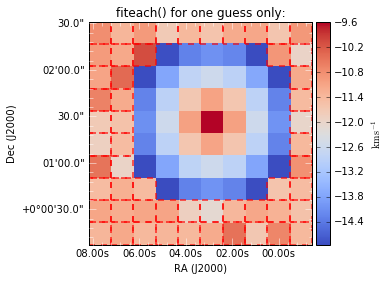

In [6]:
sc1, sc2 = sc, sc.copy()
with io.capture_output() as captured: # suppresses output, normally should not be used
    sc1.fiteach(fittype   = sc1.fittype,
                guesses   = sc1.guess_grid[sc1.best_model],
                multicore = get_ncores(),
                errmap    = sc1._rms_map,
                verbose   = 0,
                **sc1.fiteach_args)

# computing chi^2 statistics to judge the goodness of fit:
sc1.get_chi_squared(sigma=sc1.header['RMSLVL'])
sc1.chi_squared_stats()

# let's plot the velocity field:
sc1.show_fit_param(1, cmap='coolwarm')
clb = sc1.mapplot.FITSFigure.colorbar
clb.set_axis_label_text(sc1.xarr.unit.to_string('latex_inline'))
sc1.mapplot.FITSFigure.set_title("fiteach() for one guess only:")

# and overlay the pixels that didn't converge properly:
sc1.mark_bad_fits()

Because the same guess was used across the cube with varying velocity centroid, it isn't surprising that the fit failed to converge outside the central spot. Normally, a combination of `start_from_point=(x,y)` and `use_neighbor_as_guess=True` arguments can be passed to `pyspeckit.Cube.fiteach` to gradually spread from (x,y) and avoid divergence in this case, but this approach
* breaks down for large gradients/discontinuities in parameter space
* doesn't work that well when `multicore` is set to a relatively high number.

### Example #2: fitting the cube best models for each x,y pixel:

INFO:astropy:Left region selection unchanged.  xminpix, xmaxpix: 0,300


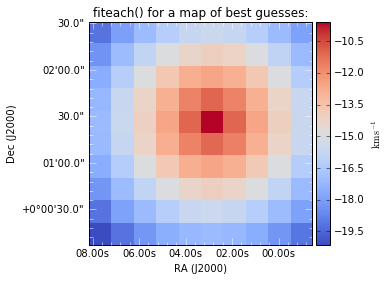

In [7]:
with io.capture_output() as captured: # suppresses output, normally should not be used
    sc2.fiteach(fittype   = sc2.fittype,
                guesses   = sc2.guess_grid[sc2.best_map].T,
                multicore = get_ncores(),
                errmap    = sc2._rms_map,
                verbose   = 0,
                **sc2.fiteach_args);

# computing chi^2 statistics to judge the goodness of fit:
sc2.get_chi_squared(sigma=sc2.header['RMSLVL'], refresh=True)
sc2.chi_squared_stats()

sc2.show_fit_param(1, cmap='coolwarm')
clb = sc2.mapplot.FITSFigure.colorbar
clb.set_axis_label_text(sc2.xarr.unit.to_string('latex_inline'))
sc2.mapplot.FITSFigure.set_title("fiteach() for a map of best guesses:")

# and overlay the pixels that didn't converge properly:
sc2.mark_bad_fits() # voila! all the pixels are fit!